In [1]:
%%capture
!pip install ipywidgets
!pip install autogluon scikit-learn==1.5.2

In [2]:
%%capture
!apt-get install -y graphviz graphviz-dev && pip install pydot
!pip install pygraphviz

In [3]:
import torch
import os
import pydot

import numpy as np
import pandas as pd
from time import time
from tqdm.auto import tqdm
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
# pd.options.mode.copy_on_write = True
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

In [4]:
### Load Data ###
PATH = "/kaggle/input/playground-series-s5e10/"
submit = pd.read_csv(PATH+"sample_submission.csv")
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)

ORIG_PATH = "/kaggle/input/simulated-roads-accident-data/"
orig = pd.concat(
    [
        pd.read_csv(ORIG_PATH+"synthetic_road_accidents_100k.csv"),
        pd.read_csv(ORIG_PATH+"synthetic_road_accidents_10k.csv"),
        pd.read_csv(ORIG_PATH+"synthetic_road_accidents_2k.csv")
    ],
    ignore_index=True)

TARGET = "accident_risk"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
FEATURES = NUMS + CATS

In [5]:
display(orig.head())
orig.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,rural,2,0.29,70,night,rainy,False,True,evening,False,False,1,0.64
1,highway,1,0.34,25,dim,clear,False,False,morning,False,False,3,0.27
2,rural,2,0.76,70,night,foggy,True,False,evening,True,True,1,0.76
3,rural,3,0.37,70,night,foggy,True,False,morning,False,True,0,0.60
4,highway,3,0.39,45,dim,rainy,False,True,morning,False,False,0,0.17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112000 entries, 0 to 111999
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               112000 non-null  object 
 1   num_lanes               112000 non-null  int64  
 2   curvature               112000 non-null  float64
 3   speed_limit             112000 non-null  int64  
 4   lighting                112000 non-null  object 
 5   weather                 112000 non-null  object 
 6   road_signs_present      112000 non-null  bool   
 7   public_road             112000 non-null  bool   
 8   time_of_day             112000 non-null  object 
 9   holiday                 112000 non-null  bool   
 10  school_season           112000 non-null  bool   
 11  num_reported_accidents  112000 non-null  int64  
 12  accident_risk           112000 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 8.1+ MB


In [6]:
def plot_heatmap(data, cat_features: list, title: str):
    df = data.copy()
    for c in cat_features:
        df[c], _ = pd.factorize(df[c])
    plt.figure(figsize=(18, 7))
    sns.heatmap(df.corr('spearman'), mask=np.triu(df.corr('spearman')), annot=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()

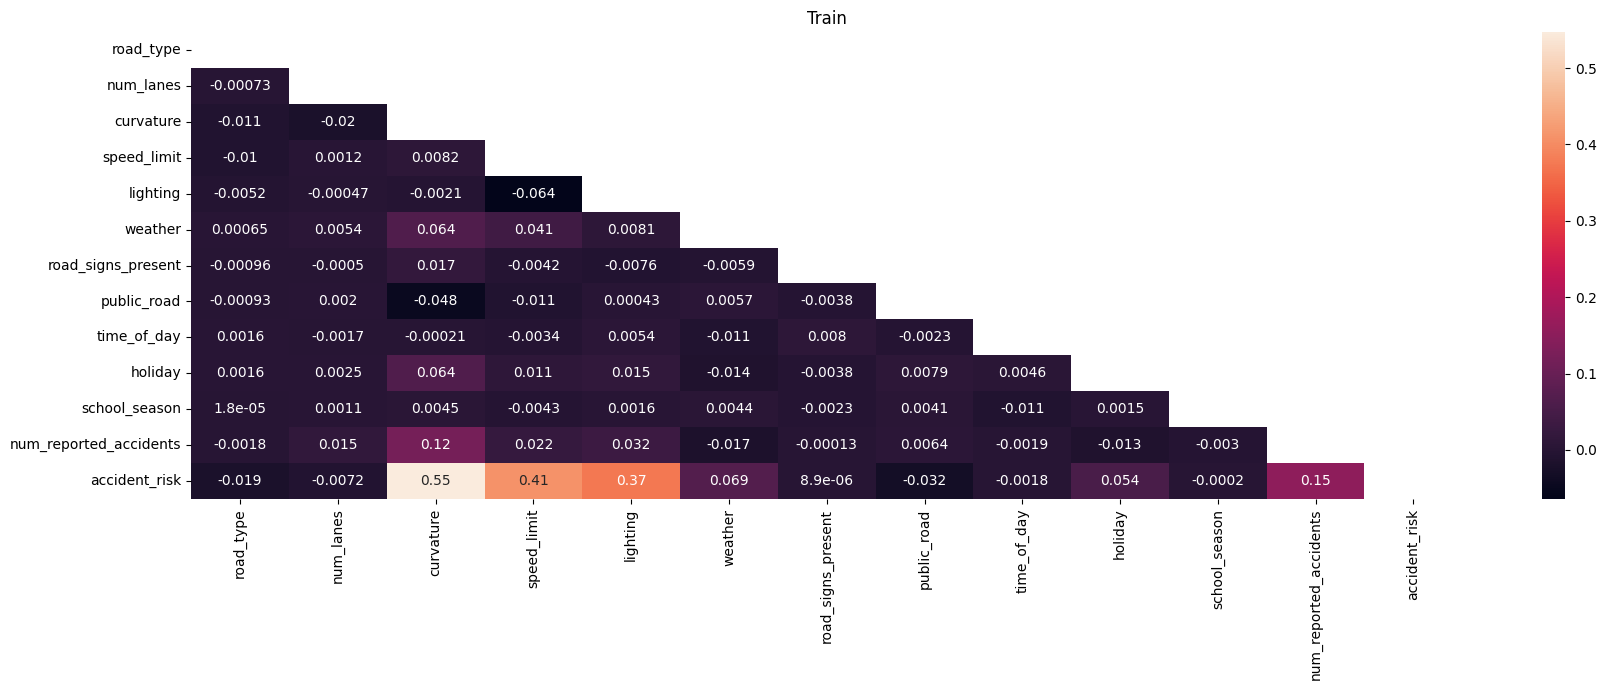

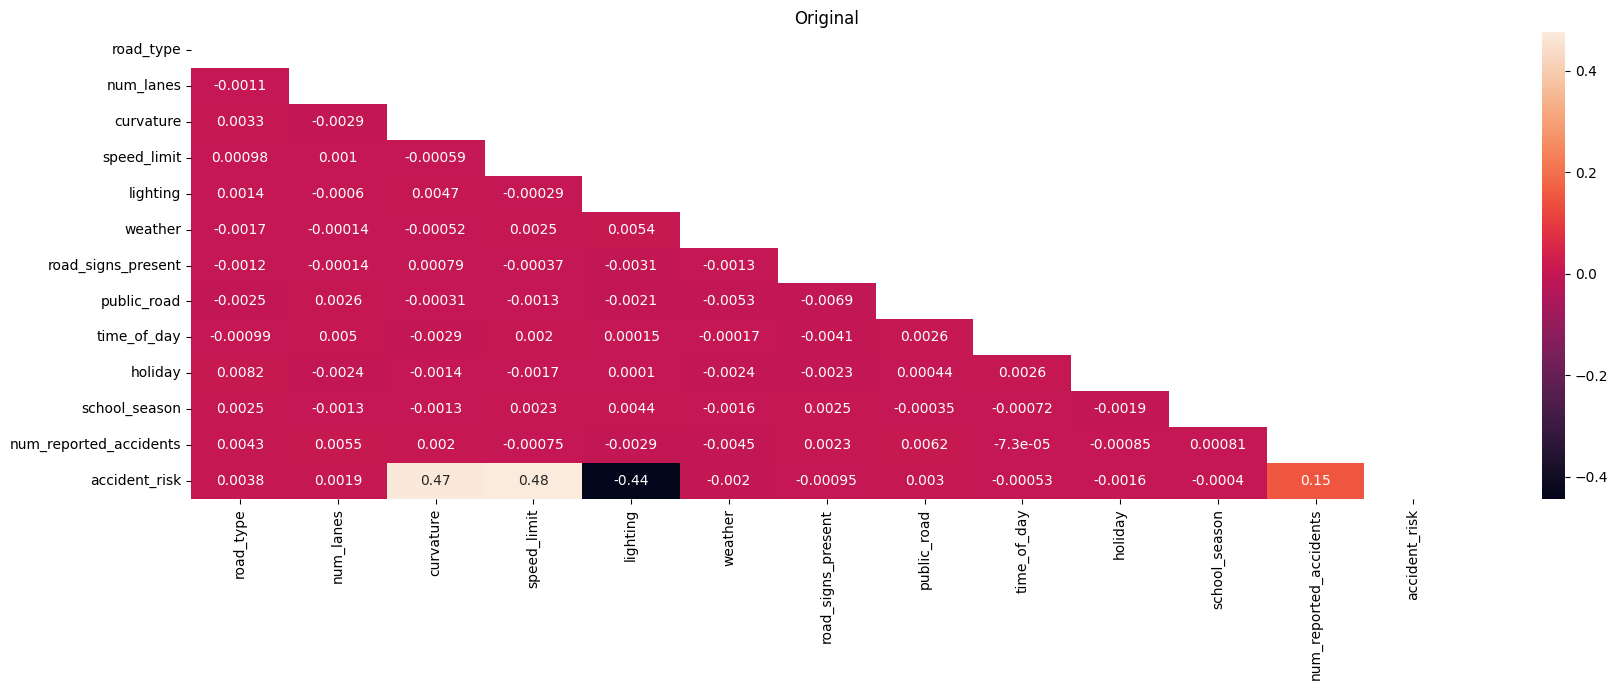

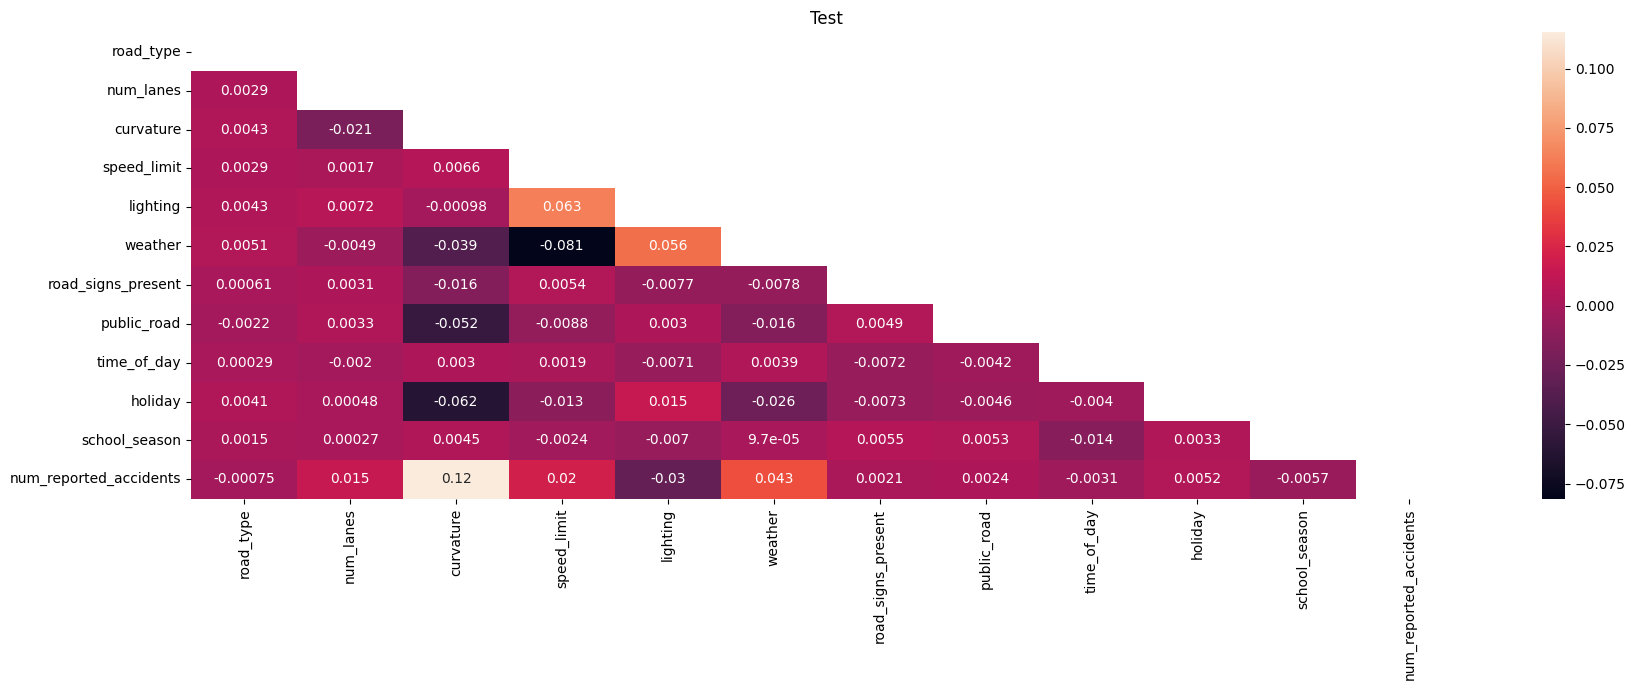

In [7]:
plot_heatmap(train, CATS, "Train")
plot_heatmap(orig, CATS, "Original")
plot_heatmap(test, CATS, "Test")

In [8]:
## -- CREATE FEATURES -- ##
def create_features(train, test, orig):
    TOP_PREDICTORS = ['curvature','speed_limit','lighting','weather','num_reported_accidents']

    ## -- FEATURE 1: Use original as features
    print(f"Merging {len(TOP_PREDICTORS)} features... ", end="")
    ORIG = []
    for c in TOP_PREDICTORS:
        tmp = orig.groupby(c)[TARGET].mean()
        n = f"orig_{c}"
        print(f"{n}, ", end="")
        tmp.name = n
        train = train.merge(tmp, on=c, how='left')
        test  = test.merge(tmp, on=c, how='left')

        ORIG.append(n)

    print()

    ## -- Pilynimial features --
    df = pd.concat([train, test], ignore_index=True)
    for col in CATS:
        df[col], _ = pd.factorize(df[col])

    df['curvature_bin'] = pd.cut(df['curvature'], bins=np.linspace(0, 1, 5), include_lowest=True, labels=False)
    df['curvature_sqrt'] = np.sqrt(df['curvature']) # Square-root
    df['curvature_squared'] = df['curvature'] ** 2 # Squared
    df['curvature_cubed'] = df['curvature'] ** 3 # Cubed
    df['curve+speed+light'] = df[['curvature', 'speed_limit', 'lighting']].sum(axis=1)
    print(f"✅ Polynomial features created!")

    ## -- meta feature --
    base_risk = (
            0.3 * df["curvature"] +
            0.2 * (df["lighting"] == "night").astype(int) +
            0.1 * (df["weather"] != "clear").astype(int) +
            0.2 * (df["speed_limit"] >= 60).astype(int) +
            0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
        )
    df['meta'] = base_risk
    print(f"✅ 'meta' feature created!")

    train = df.iloc[:len(train)].reset_index(drop=True)
    test  = df.iloc[len(train):].drop(TARGET, axis=1).reset_index(drop=True)

    ## -- Duplicate all features into categorical --
    BOOLS = train.select_dtypes(include=bool).columns
    print(f"Creating categories: ", end="")
    for c in FEATURES+ORIG:
        if c not in BOOLS:
            n = f"cat_{c}"
            print(f"{n}..", end="")
            train[n] = train[c].astype('category')
            cat = train[n].cat
            test[n] = pd.Categorical(test[c], categories=cat.categories)
    print()
            
    # ## -- Pairwise combinations --
    # TE_2 = []
    # for n in [2]:
    #     for cols in tqdm(list(combinations(FEATURES, n)), desc="Creating Pairwise"):
    #         name = '-'.join(sorted(cols))

    #         # Create combos by concatenating string representations
    #         train[name] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
    #         test[name] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)

    #         # Fit the category encoder ONLY on the training data
    #         train[name] = train[name].astype('category')
    #         cat = train[name].cat
    #         # Apply consistent encoding across datasets
    #         train[name] = train[name].cat.codes
    #         # Use the fitted category to transform the test set
    #         test[name] = pd.Categorical(test[name], categories=cat.categories).codes

    #         TE_2.append(name)

    # ## -- Triplewise combinations --
    # TE_3 = []

    # for n in [3]:
    #     for cols in tqdm(list(combinations(TOP_PREDICTORS, n)), desc="Creating Triplewise"):
    #         nm = '-'.join(sorted(cols))
    #         train[nm] = train[cols[0]].astype(str) + '_' + \
    #                     train[cols[1]].astype(str) + '_' + \
    #                     train[cols[2]].astype(str)
    #         test[nm ] = test[cols[0]].astype(str) + '_' + \
    #                     test[cols[1]].astype(str) + '_' + \
    #                     test[cols[2]].astype(str)

    #         train[nm] = train[nm].astype('category')
    #         cat = train[nm].cat
    #         train[nm] = train[nm].cat.codes
    #         test[nm] = pd.Categorical(test[nm], categories=cat.categories).codes

    #         TE_3.append(name)

    # TE = TE_2+TE_3

    print(f"{COLOR}{'='*50}")
    print(f"ℹ️ Feature Engineering Complete!")
    print(f"ℹ️ Total features: {len(test.columns)}")
    print(f"{'='*50}")

    return train, test

In [9]:
train, test = create_features(train, test, orig)

Merging 5 features... orig_curvature, orig_speed_limit, orig_lighting, orig_weather, orig_num_reported_accidents, 
✅ Polynomial features created!
✅ 'meta' feature created!
Creating categories: cat_num_lanes..cat_curvature..cat_speed_limit..cat_num_reported_accidents..cat_road_type..cat_lighting..cat_weather..cat_road_signs_present..cat_public_road..cat_time_of_day..cat_holiday..cat_school_season..cat_orig_curvature..cat_orig_speed_limit..cat_orig_lighting..cat_orig_weather..cat_orig_num_reported_accidents..
ℹ️ Feature Engineering Complete!
ℹ️ Total features: 40


In [10]:
# sns.lmplot(train.sample(frac=0.5), x='curvature', y=TARGET, hue='high_risk', 
#            seed=0, ci=None, aspect=3.0)
# plt.show()

In [11]:
display(train.head())
train.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,orig_curvature,orig_speed_limit,orig_lighting,orig_weather,orig_num_reported_accidents,curvature_bin,curvature_sqrt,curvature_squared,curvature_cubed,curve+speed+light,meta,cat_num_lanes,cat_curvature,cat_speed_limit,cat_num_reported_accidents,cat_road_type,cat_lighting,cat_weather,cat_road_signs_present,cat_public_road,cat_time_of_day,cat_holiday,cat_school_season,cat_orig_curvature,cat_orig_speed_limit,cat_orig_lighting,cat_orig_weather,cat_orig_num_reported_accidents
0,0,2,0.06,35,0,0,0,0,0,0,0,1,0.13,0.257733,0.302750,0.317262,0.417100,0.362937,0,0.244949,0.0036,0.000216,35.06,0.118,2,0.06,35,1,0,0,0,0,0,0,0,0,0.257733,0.302750,0.317262,0.417100,0.362937
1,0,4,0.99,35,0,1,1,1,1,1,0,0,0.35,0.524877,0.302750,0.317262,0.316538,0.364480,3,0.994987,0.9801,0.970299,35.99,0.397,4,0.99,35,0,0,0,1,1,1,1,1,0,0.524877,0.302750,0.317262,0.316538,0.364480
2,1,4,0.63,70,1,1,0,0,2,1,1,2,0.30,0.426885,0.503229,0.316692,0.316538,0.363730,2,0.793725,0.3969,0.250047,71.63,0.489,4,0.63,70,2,1,1,1,0,0,2,1,1,0.426885,0.503229,0.316692,0.316538,0.363730
3,2,4,0.07,35,1,0,1,0,2,0,1,1,0.21,0.244335,0.302750,0.316692,0.417100,0.362937,0,0.264575,0.0049,0.000343,36.07,0.121,4,0.07,35,1,2,1,0,1,0,2,0,1,0.244335,0.302750,0.316692,0.417100,0.362937
4,1,1,0.58,60,0,2,0,1,1,1,1,1,0.56,0.409345,0.502197,0.317262,0.415970,0.362937,2,0.761577,0.3364,0.195112,60.58,0.474,1,0.58,60,1,1,0,2,0,1,1,1,1,0.409345,0.502197,0.317262,0.415970,0.362937


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 41 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   road_type                        517754 non-null  int64   
 1   num_lanes                        517754 non-null  int64   
 2   curvature                        517754 non-null  float64 
 3   speed_limit                      517754 non-null  int64   
 4   lighting                         517754 non-null  int64   
 5   weather                          517754 non-null  int64   
 6   road_signs_present               517754 non-null  int64   
 7   public_road                      517754 non-null  int64   
 8   time_of_day                      517754 non-null  int64   
 9   holiday                          517754 non-null  int64   
 10  school_season                    517754 non-null  int64   
 11  num_reported_accidents           517754 non-null  in

In [12]:
display(test.head())
test.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,orig_curvature,orig_speed_limit,orig_lighting,orig_weather,orig_num_reported_accidents,curvature_bin,curvature_sqrt,curvature_squared,curvature_cubed,curve+speed+light,meta,cat_num_lanes,cat_curvature,cat_speed_limit,cat_num_reported_accidents,cat_road_type,cat_lighting,cat_weather,cat_road_signs_present,cat_public_road,cat_time_of_day,cat_holiday,cat_school_season,cat_orig_curvature,cat_orig_speed_limit,cat_orig_lighting,cat_orig_weather,cat_orig_num_reported_accidents
0,2,2,0.34,45,2,1,1,0,0,1,0,1,0.341785,0.302929,0.514757,0.316538,0.362937,1,0.583095,0.1156,0.039304,47.34,0.202,2,0.34,45,1,2,2,1,1,0,0,1,0,0.341785,0.302929,0.514757,0.316538,0.362937
1,0,3,0.04,45,1,2,1,1,0,1,1,0,0.244524,0.302929,0.316692,0.415970,0.364480,0,0.200000,0.0016,0.000064,46.04,0.112,3,0.04,45,0,0,1,2,1,1,0,1,1,0.244524,0.302929,0.316692,0.415970,0.364480
2,0,2,0.59,35,1,1,1,1,0,1,0,1,0.414431,0.302750,0.316692,0.316538,0.362937,2,0.768115,0.3481,0.205379,36.59,0.277,2,0.59,35,1,0,1,1,1,1,0,1,0,0.414431,0.302750,0.316692,0.316538,0.362937
3,1,4,0.95,35,0,0,0,1,0,0,1,2,0.518590,0.302750,0.317262,0.417100,0.363730,3,0.974679,0.9025,0.857375,35.95,0.385,4,0.95,35,2,1,0,0,0,1,0,0,1,0.518590,0.302750,0.317262,0.417100,0.363730
4,2,2,0.86,35,0,1,1,1,1,0,0,3,0.479198,0.302750,0.317262,0.316538,0.465450,3,0.927362,0.7396,0.636056,35.86,0.458,2,0.86,35,3,2,0,1,1,1,1,0,0,0.479198,0.302750,0.317262,0.316538,0.465450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 40 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   road_type                        172585 non-null  int64   
 1   num_lanes                        172585 non-null  int64   
 2   curvature                        172585 non-null  float64 
 3   speed_limit                      172585 non-null  int64   
 4   lighting                         172585 non-null  int64   
 5   weather                          172585 non-null  int64   
 6   road_signs_present               172585 non-null  int64   
 7   public_road                      172585 non-null  int64   
 8   time_of_day                      172585 non-null  int64   
 9   holiday                          172585 non-null  int64   
 10  school_season                    172585 non-null  int64   
 11  num_reported_accidents           172585 non-null  in

In [13]:
# !rm -r /kaggle/working/AG_accident_models

In [14]:
from autogluon.tabular import TabularPredictor

## -- RUN 1: Use train data --
predictor = TabularPredictor(
                label = TARGET,
         problem_type = "regression",
          eval_metric = "rmse",
                 path = "./AG_accident_models",
).fit(
                   train_data = train,
                      presets = 'best',
                num_bag_folds = 8,
             dynamic_stacking = False,
             num_stack_levels = 1,
                 # num_bag_sets = 2,
                   time_limit = 3600*11,
        # [ 'XGB', 'GBM', 'CAT', 'RF', 'XT', 'FASTAI', 'NN_TORCH']
         # included_model_types = ['RF', 'XT', 'FASTAI'],
                     # num_gpus = torch.cuda.device_count(),
                  # ag_args_fit = {'num_cpus': os.cpu_count() - 1},
)

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.59 GB / 31.35 GB (94.4%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 39600s
AutoGluon will save models to "/kaggle/working/AG_accident_models"
Train Data Rows:    517754
Train Data Columns: 40
Label Column:       accident_risk
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                  

In [15]:
## -- Get Summary -- 
print(f"""
    ---> Total models : {len(predictor.model_names())}
    ---> Best model   : {predictor.model_best}
        """)

## -- Observe RUN 1 RESULTS --
leaderboard = predictor.leaderboard(silent=True)
display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))


    ---> Total models : 19
    ---> Best model   : WeightedEnsemble_L3
        


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.055803,root_mean_squared_error,241.543695,29011.111259,0.013145,1.629771,3,True,19
1,ExtraTreesMSE_BAG_L2,-0.055850,root_mean_squared_error,208.630895,26818.242315,27.716522,536.348939,2,True,15
2,WeightedEnsemble_L2,-0.055900,root_mean_squared_error,77.492312,21987.682169,0.011012,0.834542,2,True,10
3,LightGBM_BAG_L2,-0.055930,root_mean_squared_error,186.430632,26355.052582,5.516259,73.159207,2,True,12
4,CatBoost_BAG_L2,-0.055934,root_mean_squared_error,185.283281,34941.867808,4.368908,8659.974433,2,True,14
5,NeuralNetFastAI_BAG_L2,-0.055940,root_mean_squared_error,189.261491,27296.648039,8.347117,1014.754663,2,True,16
6,NeuralNetFastAI_BAG_L1,-0.055949,root_mean_squared_error,8.999718,1297.079105,8.999718,1297.079105,1,True,6
7,CatBoost_BAG_L1,-0.055998,root_mean_squared_error,21.503382,20187.462795,21.503382,20187.462795,1,True,4
8,LightGBMXT_BAG_L2,-0.056023,root_mean_squared_error,189.090286,26361.194358,8.175912,79.300983,2,True,11
9,LightGBMLarge_BAG_L1,-0.056031,root_mean_squared_error,23.119968,115.232720,23.119968,115.232720,1,True,9


In [16]:
## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
#                 ag_args_fit  = {'num_cpus': os.cpu_count() - 1},
# )

In [17]:
## -- Get Summary -- 
# print(f"""
#     # {'█'*5}| Total models : {len(predictor.model_names())}
#     # {'█'*5}| Best model   : {predictor.model_best}
#         """)

# # -- Observe RUN 2 RESULTS --
# leaderboard = predictor.leaderboard(silent=True)
# display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))

In [18]:
## -- Create folder directory to save predictions --
NAME_EXT = "_FE40-CPU"
FOLDER   = "AG_accident_predictions"
!mkdir /kaggle/working/{FOLDER}{NAME_EXT}

In [19]:
## -- Make predictions from best model --
pred_df = predictor.predict(test)

## -- Make Submission --
submit = pd.read_csv(PATH+"sample_submission.csv")

SUBMIT_FILE = f'submit_AG{NAME_EXT}.csv'
submit[TARGET] = pred_df.values
submit.to_csv(SUBMIT_FILE, index=False)
print(f"---> Submission file saved as: {SUBMIT_FILE} !")
submit.head(10)

---> Submission file saved as: submit_AG_FE40-CPU.csv !


,id,accident_risk
0,517754,0.296858
1,517755,0.120825
2,517756,0.180303
3,517757,0.310004
4,517758,0.404154
5,517759,0.464309
6,517760,0.256635
7,517761,0.197953
8,517762,0.379530
9,517763,0.323832


In [20]:
## -- Generate prediction probabilities for all models --
ag_multi_test_proba = predictor.predict_multi(test)

## -- Get TEST PREDICTIONS of all models --
final_test_data = {}
DESC = "Exporting TEST predictions"

for k, v in tqdm(ag_multi_test_proba.items(), desc=DESC):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_test_data[k_renamed] = v

SAVE_PRED = f"/kaggle/working/{FOLDER}{NAME_EXT}/pred_ag{NAME_EXT}.parquet"
final_test_df = pd.DataFrame(final_test_data)
final_test_df.to_parquet(SAVE_PRED, index=False)
final_test_df.head()

Exporting TEST predictions:   0%|          | 0/19 [00:00<?, ?it/s]

,LightGBMXTBAGL1_FE40-CPU,LightGBMBAGL1_FE40-CPU,RandomForestMSEBAGL1_FE40-CPU,CatBoostBAGL1_FE40-CPU,ExtraTreesMSEBAGL1_FE40-CPU,NeuralNetFastAIBAGL1_FE40-CPU,XGBoostBAGL1_FE40-CPU,NeuralNetTorchBAGL1_FE40-CPU,LightGBMLargeBAGL1_FE40-CPU,WeightedEnsembleL2_FE40-CPU,LightGBMXTBAGL2_FE40-CPU,LightGBMBAGL2_FE40-CPU,RandomForestMSEBAGL2_FE40-CPU,CatBoostBAGL2_FE40-CPU,ExtraTreesMSEBAGL2_FE40-CPU,NeuralNetFastAIBAGL2_FE40-CPU,XGBoostBAGL2_FE40-CPU,NeuralNetTorchBAGL2_FE40-CPU,WeightedEnsembleL3_FE40-CPU
0,0.292533,0.290152,0.315779,0.292578,0.312746,0.290498,0.292593,0.308125,0.290532,0.292686,0.294870,0.294200,0.298014,0.293396,0.300251,0.291711,0.295654,0.313523,0.296858
1,0.121555,0.120958,0.120043,0.122121,0.120002,0.120049,0.125992,0.133833,0.122636,0.121007,0.120257,0.122560,0.120564,0.121370,0.120970,0.122196,0.131369,0.126835,0.120825
2,0.181537,0.184898,0.173481,0.186746,0.175384,0.177681,0.185152,0.199567,0.177266,0.180048,0.178237,0.177640,0.181353,0.181515,0.179687,0.180648,0.187060,0.194374,0.180303
3,0.325127,0.320776,0.320776,0.309453,0.316816,0.306138,0.334203,0.340815,0.323953,0.310393,0.320301,0.314150,0.309266,0.314382,0.312090,0.310143,0.314870,0.332691,0.310004
4,0.401007,0.392153,0.408096,0.392891,0.409898,0.396116,0.401123,0.380866,0.404639,0.397397,0.403935,0.396809,0.405529,0.399233,0.409771,0.395655,0.393059,0.389279,0.404154


In [21]:
## -- Get OOF predictions of all models --
ag_multi_oof_preds = {}
DESC1 = "Processing OOF probabilities"

for model in tqdm(predictor.model_names(), desc=DESC1):
    ag_multi_oof_preds[model] = predictor.predict_oof(
                                     model = model,
                                train_data = train
                            )

final_oof_data = {}
DESC2 = "Exporting OOF predictions"

for k, v in tqdm(ag_multi_oof_preds.items(), desc=DESC2):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_oof_data[k_renamed] = v
    
SAVE_OOF = f"/kaggle/working/{FOLDER}{NAME_EXT}/oof_ag{NAME_EXT}.parquet"
final_oof_df = pd.DataFrame(final_oof_data)
final_oof_df.to_parquet(SAVE_OOF, index=False)
final_oof_df.head()

Processing OOF probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Exporting OOF predictions:   0%|          | 0/19 [00:00<?, ?it/s]

,LightGBMXTBAGL1_FE40-CPU,LightGBMBAGL1_FE40-CPU,RandomForestMSEBAGL1_FE40-CPU,CatBoostBAGL1_FE40-CPU,ExtraTreesMSEBAGL1_FE40-CPU,NeuralNetFastAIBAGL1_FE40-CPU,XGBoostBAGL1_FE40-CPU,NeuralNetTorchBAGL1_FE40-CPU,LightGBMLargeBAGL1_FE40-CPU,WeightedEnsembleL2_FE40-CPU,LightGBMXTBAGL2_FE40-CPU,LightGBMBAGL2_FE40-CPU,RandomForestMSEBAGL2_FE40-CPU,CatBoostBAGL2_FE40-CPU,ExtraTreesMSEBAGL2_FE40-CPU,NeuralNetFastAIBAGL2_FE40-CPU,XGBoostBAGL2_FE40-CPU,NeuralNetTorchBAGL2_FE40-CPU,WeightedEnsembleL3_FE40-CPU
0,0.129581,0.128400,0.129079,0.129344,0.129357,0.128151,0.129769,0.151967,0.130225,0.128874,0.131465,0.128875,0.127966,0.131341,0.128393,0.127166,0.137742,0.125069,0.128374
1,0.320147,0.319411,0.322848,0.328347,0.321396,0.324340,0.324520,0.325713,0.321283,0.324838,0.322113,0.324602,0.323667,0.324555,0.321237,0.324757,0.325097,0.336533,0.323121
2,0.388561,0.389492,0.389062,0.389881,0.385548,0.385572,0.389894,0.399215,0.388492,0.387219,0.389848,0.388797,0.373848,0.388023,0.382983,0.386036,0.388678,0.389307,0.382803
3,0.131553,0.128843,0.132962,0.131045,0.132376,0.132923,0.129742,0.141680,0.133098,0.132372,0.133365,0.134938,0.130931,0.131591,0.130773,0.130628,0.142109,0.135215,0.131307
4,0.470775,0.469618,0.473213,0.470386,0.466073,0.468304,0.467585,0.450888,0.469619,0.468928,0.468264,0.471054,0.472723,0.470820,0.462874,0.469170,0.465364,0.468165,0.466557


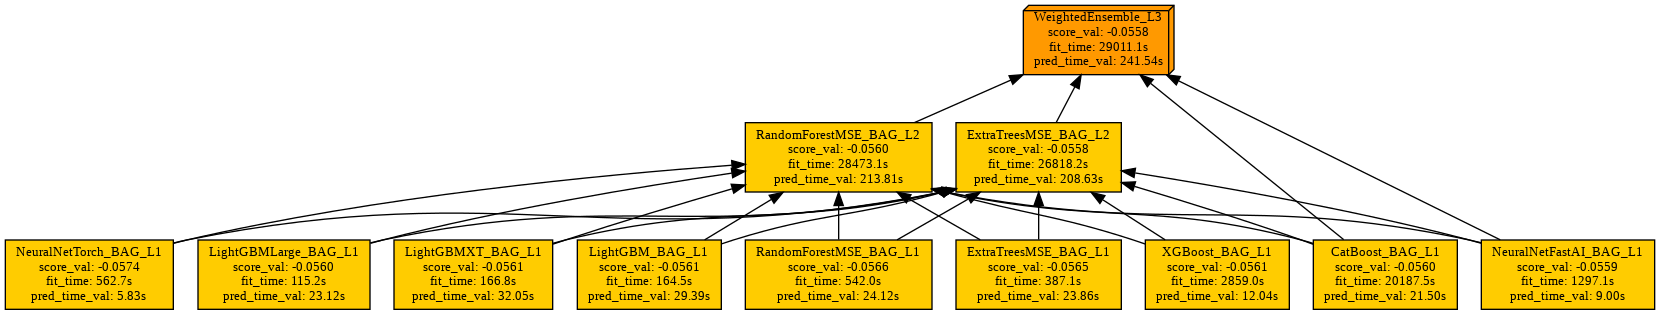

In [22]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image('./AG_accident_models/ensemble_model.png'))

In [23]:
# !zip -r /kaggle/working/AG_accident_models /kaggle/working/AG_accident_models.zip
!zip -r {FOLDER}{NAME_EXT}.zip /kaggle/working/{FOLDER}{NAME_EXT}

  adding: kaggle/working/AG_accident_predictions_FE40-CPU/ (stored 0%)
  adding: kaggle/working/AG_accident_predictions_FE40-CPU/pred_ag_FE40-CPU.parquet (deflated 9%)
  adding: kaggle/working/AG_accident_predictions_FE40-CPU/oof_ag_FE40-CPU.parquet (deflated 10%)


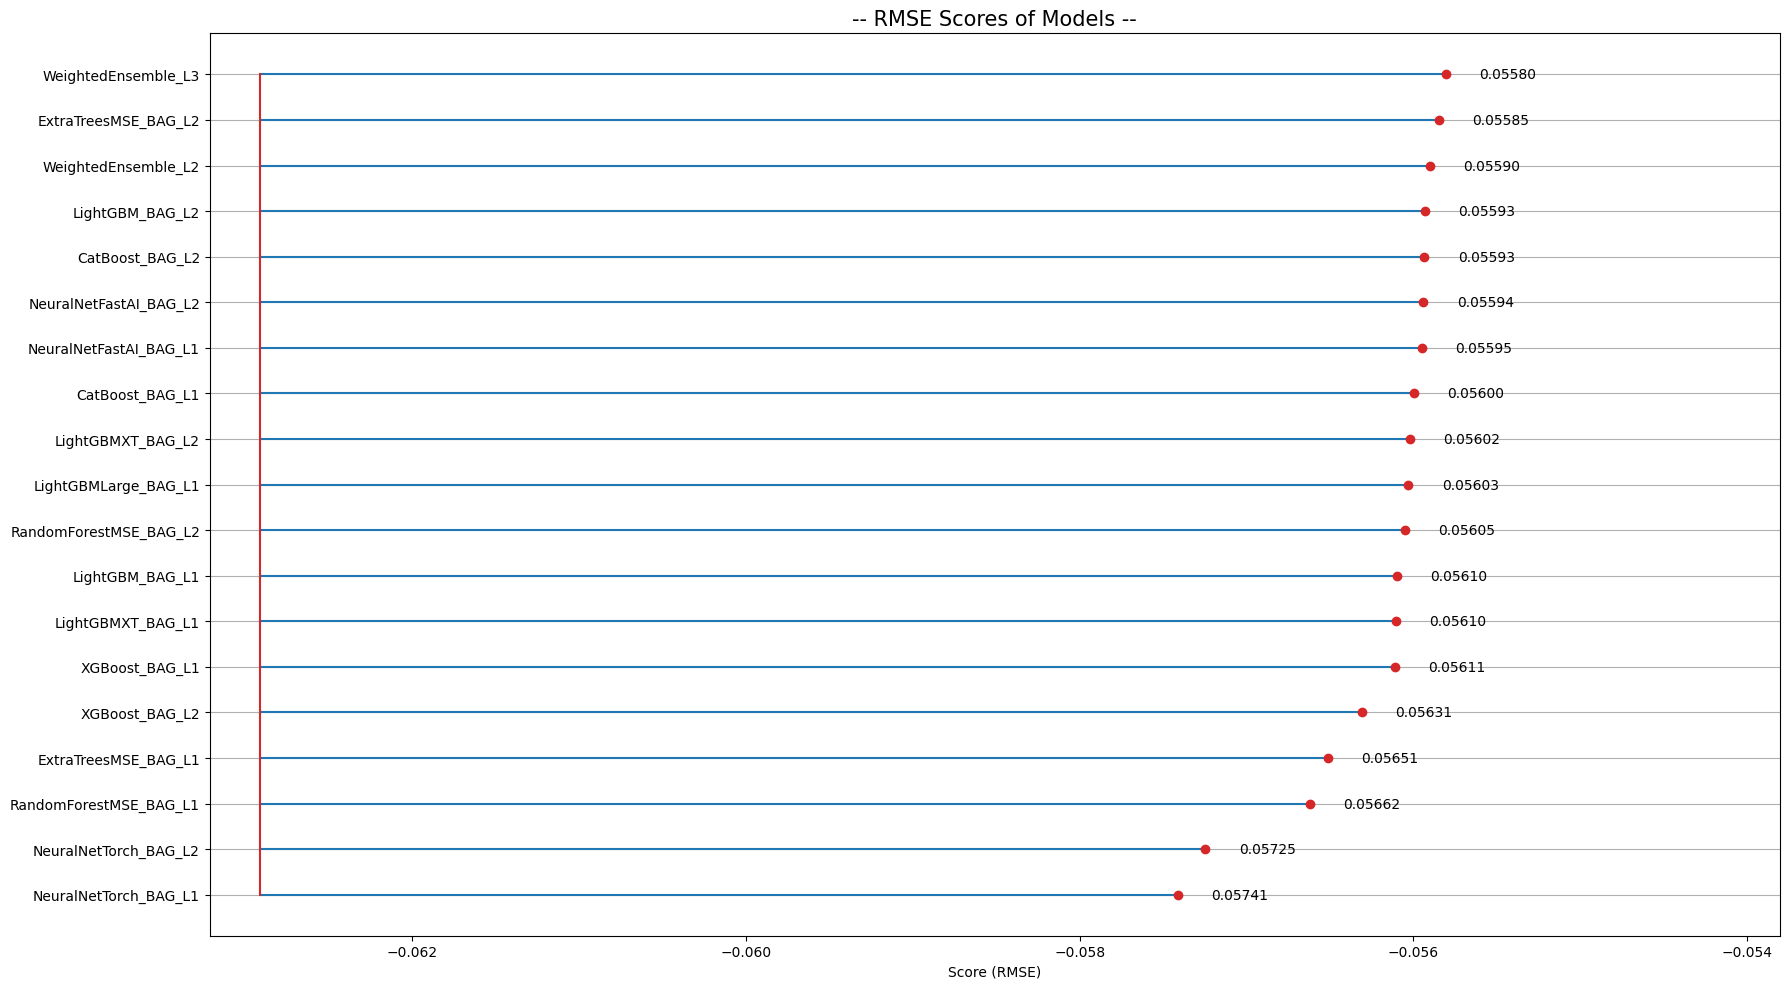

In [24]:
## -- EXTRACT MODEL AND SCORES --
result_dict = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_dict, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(18, 10))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.0058, max_score + 0.002)
plt.xlabel('Score (RMSE)')
plt.title('-- RMSE Scores of Models --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+2e-4, i, f'{abs(value):.5f}', ha='left', va='center')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [25]:
## -- OPTIONAL: Remove stored files --
!rm -r /kaggle/working/AG_accident_models
!rm -r /kaggle/working/{FOLDER}{NAME_EXT}

In [26]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------

